In [17]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [18]:
%%cython -a
import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

In [27]:
import sklearn
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt

In [28]:
%%cython -a
import time
import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp
import matplotlib.pyplot as plt

cdef class HASH_FUNS():
    
    cdef public int C,d,k,l,T,N,total_number_of_cluster,iteration_times
    cdef public double A,r
    cdef public double[:,:] points_distances
    cdef public long[:,:] data,RP,BP
    cdef public long[:] core_points,not_noise_points,latest_cluster, near_points
    cdef public double[:,:] single_linkage_matrix
    
    def __cinit__(self, long[:,:]data):
        '''
        Initialize raw data, max value(C), dimension(d), 
            number of points(N), and an array maintaining the cluster index of each point
        
        self.points_distances reflect the true distance of two points. The init value is inf.
        self.RP reflect whether two points is near or note. "near" means the true distance is less than r.
        self.latest_cluster reflect the cluster label of each point, the init value is the points index.
        self.total_number_of_cluster reflect the total number of cluster. NOTE: It is not the current number of clusters.
        '''
        
        try:
            self.data = data
            #if not data.dtype == int:
                #raise TypeError
            
            self.C = np.max(self.data)
            if np.min(self.data) < 0:
                print("the minimum is", np.min(self.data))
                raise ValueError
            
            self.d = len(self.data[0])
            self.N = len(self.data)

            self.points_distances = np.array([np.array([np.inf] * self.N)] *
                                             self.N)
            self.RP = np.array([np.array([False] * self.N)] * self.N,dtype = int)            
            self.latest_cluster = np.arange(self.N,dtype = int)            
            self.total_number_of_cluster = self.N            
            self.single_linkage_matrix = np.empty((1,4))
            self.iteration_times = 0
            self.near_points = np.zeros(self.N,dtype = int)
            
        #except AttributeError:
            #print("Data size should be larger than 1")
        except TypeError:
            print("Data should be integers.")
        #except ValueError:
            #print("Data should be positive.")

    def set_parameters(self, int k, int l, double A=2, int T=0):
        '''Set up number of sampled digits(k), number of hash functions(l),
            increasing rate(A), noise exclusion threshold(T), and range of cluster inclusion r'''
        try:
            self.k = k
            if k <= 0 or not isinstance(k, int):
                raise ValueError("k should be positive integer.")
            if k > self.C*self.d:
                raise ValueError("k should be smaller than", self.C*self.d)
            self.l = l
            if l <= 0 or not isinstance(l, int):
                raise ValueError("l should be a positive integer.")
            self.A = A
            if A <= 0:
                raise ValueError("A should be positive.")
            self.T = T
            self.r = self.C*self.d/(2*self.k)*self.d**0.5
            if T > l:
                pass
            elif T <= l and T > 0:
                raise ValueError("T should be larger than l.")
            elif T < 0:
                raise ValueError("T should be non-negative.")
                
            self.create_BP()
        except ValueError:
            print('Some inputs are not right.')
            raise 
    

    def get_parameters(self):
        '''Show the current parameters'''
        print('l=',self.l,'\n')
        print('k=',self.k,'\n')
        print('r=',self.r,'\n')
        print('C=',self.C,'\n')
        print('d=',self.d,'\n')
        print('N=',self.N,'\n')
        print('A=',self.A,'\n')
        print('T=',self.T,'\n')
    
    def plot_raw_data(self):
        '''Plot the points on a 2d grid. Only 2d data allowed'''
        plt.scatter(self.data[:, 0], self.data[:, 1])   
    
  
    def fit_data(self):
        """
        Train data until all data merge into one cluster, during each phase, this function will updata points distance
        and single linkage matrix.
        
        During each phase, the function will updata r and k automatically, and the noise exclusion will 
        only be intergrated into the first phase.        
        """
        cdef int counter = 0
        cdef int length = 0
        while counter != self.N:
            self.updata_distance()
            self.update_RP()
            self.update_single_linkage_matrix()
            self.r = self.r * self.A
            self.k = int(self.C * self.d * np.sqrt(self.d) / (2 * self.r))
            self.iteration_times += 1
            
            counter = 0
            for i in range(self.N):
                if self.latest_cluster[i] == self.latest_cluster[0]:
                    counter += 1
            
        return self.single_linkage_matrix
    

    def updata_distance(self):
        """
        This function will update distance in every phase.
        
        self.near_points reflect the number of points near the point in every bucket.
        
        self.hash_value function return a matrix, which shape is (l * N * k). It contains l hash tables.
        for each hash table, we calculate the bucket and for each bucket, we calculate the points distances.
        """
        cdef float start, end
        self.near_points = np.zeros(self.N,dtype = int)
        for hash_table in self.hash_value():
            candidates = self.idenfity_candidates(hash_table)
            for lis in candidates:
                self.judge_cluster_by_distance(lis)
        #print('already update points distance')
        
    def update_RP(self):
        """
        self.RP identify each two points is near or not.
            if two points p q is near, then self.RP[p,q] is True.
        
        self.not_noise_points is only used in the first phase, which will be used to judge noise point.
            if one points p is not noise, then the value is True.     
            
        self.near_points reflect the near points of the point p in all bucket in all hash functions. 
        self.core_points reflect whether the near points of the point p is bigger than T.
        """
        
        for i in range(self.N):
            for j in range(self.N):
                self.RP[i,j] += self.points_distances[i,j] < self.r  
        if self.iteration_times == 0:
            self.core_points = np.empty(self.N,dtype = int)
            self.not_noise_points = np.array([False]* self.N,dtype = int)
            for i in range(self.N):
                self.core_points[i] = (self.near_points[i] > self.T)
                self.not_noise_points[i] += self.core_points[i]

                if self.core_points[i]:
                    for j in range(self.N):
                        self.not_noise_points[j] += self.RP[i,j]
        else:
            self.not_noise_points = np.array([True]* self.N,dtype = int)
        #print(self.not_noise_points)
      
    def update_single_linkage_matrix(self):
        """
        The single linkage matrix has four columns. The first two columns are the cluster label, the third columns
            is the distance of two cluster, and the fourth columns is the number of points in the new merged cluster.
            
        In the first phase, we will only count the not noise points.
        """
        cdef int temp1,temp2,temp,ele
        cdef double[:] row = np.empty(4)
        for i in range(self.N):
            if not self.not_noise_points[i]:
                continue
            for j in range(self.N):
                ele = self.RP[i][j]
                if ele and self.latest_cluster[i] != self.latest_cluster[j]:
                    temp1 = self.latest_cluster[i]
                    temp2 = self.latest_cluster[j]
                    temp = self.update_latest_cluster(i, j)
                    row = np.array([temp1, temp2, self.r, temp])
                    self.single_linkage_matrix = np.vstack((self.single_linkage_matrix,row))
                   # print('length: ', len(self.single_linkage_matrix))
        
    def update_latest_cluster(self, int i, int j):
        """
        input: near points i, j
        ouput: the total number of cluster.
        
        For near points i,j, this functions first identify the two cluster of two points and relabel all points in this 
            two clusters into a new label, which means "merge" two cluster.
        """
        cdef int k,counter = 0
        temp1 = self.latest_cluster[i]
        temp2 = self.latest_cluster[j]
        for k in range(self.N):
            if self.latest_cluster[k] == temp1 or self.latest_cluster[k] == temp2:
                self.latest_cluster[k] = self.total_number_of_cluster
                counter += 1
                    
        self.total_number_of_cluster += 1
        return counter
    
    def create_BP(self):
        '''Create a binary table. Each row is a Cd-dimensional vector 
            transformed from the d-dimensional vector'''        
        self.r = self.C * self.d / (2 * self.k) * np.sqrt(self.d)
        self.BP = np.zeros((self.N, self.C * self.d), dtype='int')
        for i in range(self.N):
            for k in range(self.d):
                start_point = self.C * k
                number_of_one = self.data[i][k]
                self.BP[i][start_point:start_point + number_of_one] = 1
        #print("already create binary table")
        return self.BP

    def create_hash_table(self):
        '''Create a hashed table. Each row has k bits randomly chosen 
            from the Cd-dimensional vector. '''
        hash_table = np.empty([self.N,self.k],dtype = int)
        choice_value = np.random.randint(low=0, high=self.C * self.d,size=self.k)
        for k in range(self.N):
            for i,j in enumerate(choice_value):
                hash_table[k,i] = self.BP[k,j]
        return hash_table
    
    def hash_value(self):
        """
        Return a matrix with shape (l * N * k). This matrix contains l hash table.
        """
        
        table = np.zeros((self.l, self.N, self.k), dtype='int')
        for i in range(self.l):
            table[i, :, :] = self.create_hash_table()
        #print("already create hash function")
        return table
    
    def idenfity_candidates(self, long[:,:] A):
        """
        input: one hash table
        output: buckets
        
        this function calculate the buckets in one hash table. For each point p, it put the points with same hash value
            into the buckets. 
        However,if another point belonging to the same cluster as p has already been saved in the very bucket, 
            p is not stored in it.
        """
        cdef int length = A.shape[1]
        cdef list result = []
        cdef long[:] target = np.zeros(length,dtype= int)
        cdef long[:] can = np.zeros(length,dtype= int)
        cdef list temp
        cdef int x
        for i in range(self.N):
            target = A[i]
            temp = [i]
            for j in range(self.N):
                if i == j:
                    continue
                if self.latest_cluster[i] == self.latest_cluster[j]:
                    continue
                x = 1
                can = A[j]
                for m in range(length):
                    if target[m] != can[m]:
                        x = 0
                        break
                if x == 1:
                    temp.append(j)
                
            if sorted(temp) not in result:
                result.append(sorted(temp))
        return result

    def judge_cluster_by_distance(self, list lis):
        """
        input: one bucket
        
        This function will update the points_distances in one bucket. 
        For points_distance < r, count points' near points' number.
        """
        
        cdef int N = len(lis)
        cdef double dis
        for i in range(N):
            for j in range(N):
                if self.latest_cluster[i] != self.latest_cluster[j]:
                    row_num = lis[i]
                    col_num = lis[j]
                    if self.points_distances[row_num,col_num] == np.inf:
                        dis = 0

                        for k in range(self.d):
                            dis += (self.data[row_num,k]-self.data[col_num,k])**2
                        dis = dis**0.5
                        self.points_distances[row_num,col_num] = dis
                        self.points_distances[col_num,row_num] = dis
                    else:
                        dis = self.points_distances[row_num,col_num]
                    if self.iteration_times == 0 and dis < self.r:
                        self.near_points[row_num] += 1
                

# test

In [38]:
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
data = np.array(X,dtype = int)
test = HASH_FUNS(data)
test.set_parameters(4,10,2,11)
output = test.fit_data()

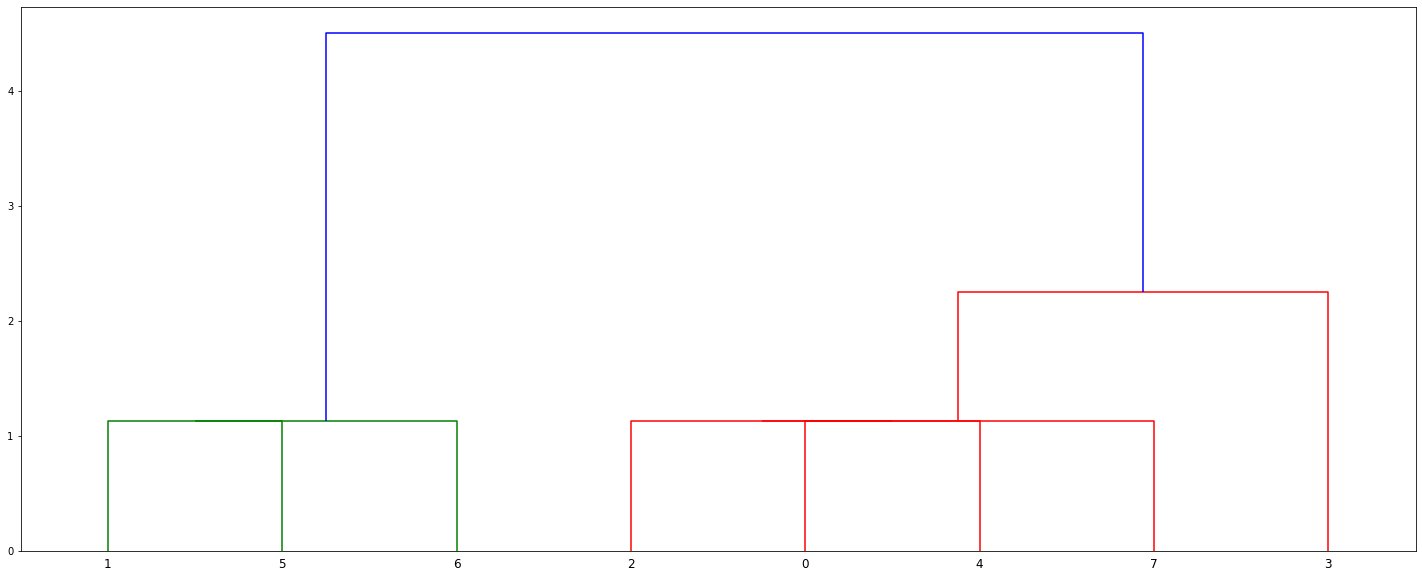

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output[1:,:])
plt.show()

In [110]:
data = sklearn.datasets.load_iris().data
data = data[:50,:]*10 - data.min(axis=0)*10
data = np.array(data, dtype='int')
test = HASH_FUNS(data)
test.set_parameters(60,20,2,25)
pass

In [111]:
output = test.fit_data()

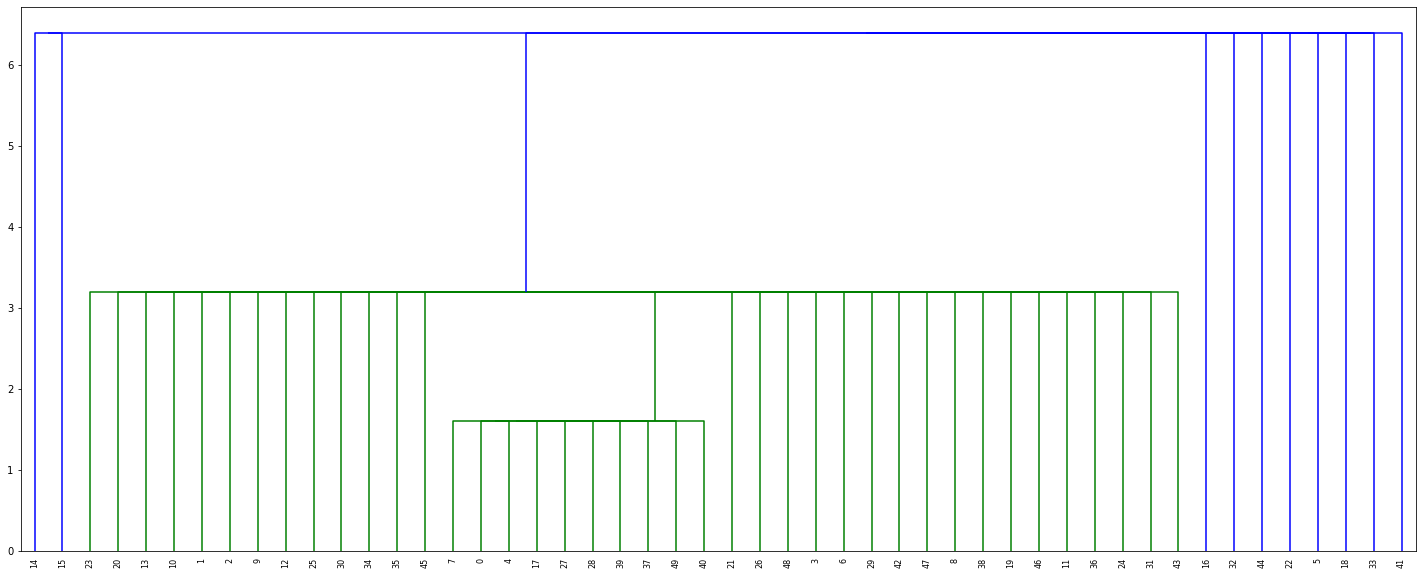

In [112]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output[1:,:])
plt.show()

In [24]:
data2 = sklearn.datasets.load_digits().data
data2 = np.array(data2[:200,:], dtype='int')

In [25]:
test2 = HASH_FUNS(data2)
test2.set_parameters(1000,20,2,25)
test2.get_parameters()

l= 20 

k= 1000 

r= 4.096 

C= 16 

d= 64 

N= 200 

A= 2.0 

T= 25 



In [ ]:
for i in range(len(test2.single_linkage_matrix)):
    ls = []
    for j in range(4):
        ls.append(test2.single_linkage_matrix[i][j])
    print(ls)

In [ ]:
output2 = test2.fit_data()

In [ ]:
ls= []
for i in range(len(output2)):
    temp = []
    temp.append(int(output2[i][0]))
    temp.append(int(output2[i][1]))
    temp.append(output2[i][2])
    temp.append(int(output2[i][3]))
    ls.append(temp)
ls[1:]

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output2[1:,:])
plt.show()

In [ ]:
data = sklearn.datasets.load_iris().data
data = data[:,:]*10 - data.min(axis=0)*10
data = np.array(data, dtype='int')

test = HASH_FUNS(data)
test.set_parameters(100,10,2,15)
pass
output = test.fit_data()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output[1:])
plt.show()

In [ ]:
data2 = sklearn.datasets.load_digits().data
data2 = np.array(data2[:150,:], dtype='int')

test2 = HASH_FUNS(data2)
test2.set_parameters(1000,20,2,25)
test2.get_parameters()

In [13]:
import time
data2 = sklearn.datasets.load_digits().data
data2 = np.array(data2[:150,:], dtype='int')

test2 = HASH_FUNS(data2)
test2.set_parameters(1000,20,2,25)
test2.get_parameters()

start = time.process_time()
test2.set_parameters(1000,20,2,25)
end = time.process_time()
print("set_parameters",str(end-start))

start = time.process_time()
test2.updata_distance()
end = time.process_time()
print("update_distance",str(end-start))

start = time.process_time()
test2.update_RP()
end = time.process_time()
print("update_RP",str(end-start))

start = time.process_time()
test2.update_single_linkage_matrix()
end = time.process_time()
print("single_linkage_matrix",str(end-start))

test2.r = test2.r * test2.A
test2.k = int(test2.C * test2.d * np.sqrt(test2.d) / (2 * test2.r))
test2.iteration_times += 1
print("first iteration end")

start = time.process_time()
test2.updata_distance()
end = time.process_time()
print("update_distance",str(end-start))

start = time.process_time()
test2.update_RP()
end = time.process_time()
print("update_RP",str(end-start))

start = time.process_time()
test2.update_single_linkage_matrix()
end = time.process_time()
print("single_linkage_matrix",str(end-start))

l= 20 

k= 1000 

r= 4.096 

C= 16 

d= 64 

N= 150 

A= 2.0 

T= 25 

set_parameters 0.002995999999996002
update_distance 1.4441839999999928
update_RP 0.0003839999999968313
single_linkage_matrix 0.0001080000000115433
first iteration end
update_distance 0.8476780000000019
update_RP 0.00030200000000490945
single_linkage_matrix 0.0004179999999962547


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output1)
plt.show()